In [1]:
# Setup
import sys
sys.path.append('../')

from src.features.hawkes_features import (
    HawkesFeatureExtractor,
    extract_hawkes_features_rolling,
    detect_excitation_regimes,
    hawkes_regime_features
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization settings
plt.style.use('seaborn-v0_8-paper')  
plt.rcParams.update({
    'font.family': 'serif',
    'font.weight': 'bold',        
    'axes.labelweight': 'bold',    
    'axes.titleweight': 'bold',   
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
})


from src.config import (
    RAW_DATA_DIR,
    INTERIM_DATA_DIR, 
    PROCESSED_DATA_DIR,
    FIGURES_DIR
)


## Poisson Test

In [3]:
import numpy as np
from src.features.hawkes_features import HawkesFeatureExtractor

# Generate Poisson test data
np.random.seed(42)
n_events = 1000
T = 100
poisson_times = np.sort(np.random.uniform(0, T, n_events))

# Fit
extractor = HawkesFeatureExtractor()
extractor.fit(poisson_times)
params = extractor.get_params()

print("Poisson test (should have low branching ratio):")
print(f"  μ (baseline):     {params['mu']:.4f} events/sec")
print(f"  α (excitation):   {params['alpha']:.4f}")
print(f"  β (decay):        {params['beta']:.4f}")
print(f"  Branching ratio:  {params['branching_ratio']:.4f}")
print(f"\n  Expected: branching ratio ≈ 0 for Poisson")
print(f"  Actual:   branching ratio = {params['branching_ratio']:.4f}")

if params['branching_ratio'] < 0.2:
    print("  ✓ Looks good - low self-excitation as expected!")
else:
    print("  ⚠ Higher than expected - but could be noise in small sample")

Poisson test (should have low branching ratio):
  μ (baseline):     9.6337 events/sec
  α (excitation):   0.0370
  β (decay):        2.9123
  Branching ratio:  0.0127

  Expected: branching ratio ≈ 0 for Poisson
  Actual:   branching ratio = 0.0127
  ✓ Looks good - low self-excitation as expected!


## Test with self-exciting data
Verify that Hawkes can detect self-excitation when it's present:

In [16]:
# Generate clustered/self-exciting data
np.random.seed(42)
clusters = []
for _ in range(20):  # 20 burst clusters
    cluster_start = np.random.uniform(0, 100)
    cluster_size = np.random.randint(30, 70)
    # Events tightly clustered (0.1 sec exponential spacing)
    cluster_times = cluster_start + np.random.exponential(0.1, cluster_size)
    clusters.extend(cluster_times)

clustered_times = np.sort(np.array(clusters))
clustered_times = clustered_times[clustered_times < 100]

# Fit
extractor2 = HawkesFeatureExtractor()
extractor2.fit(clustered_times)
params2 = extractor2.get_params()

print("\nClustered data test (should have HIGH branching ratio):")
print(f"  μ (baseline):     {params2['mu']:.4f}")
print(f"  α (excitation):   {params2['alpha']:.4f}")
print(f"  β (decay):        {params2['beta']:.4f}")
print(f"  Branching ratio:  {params2['branching_ratio']:.4f}")

if params2['branching_ratio'] > 0.5:
    print("  ✓ High self-excitation detected!")
else:
    print(f"  Moderate self-excitation (still higher than Poisson)")


Clustered data test (should have HIGH branching ratio):
  μ (baseline):     0.2850
  α (excitation):   0.9729
  β (decay):        45.4906
  Branching ratio:  0.0214
  Moderate self-excitation (still higher than Poisson)


In [17]:
clustered_times

array([ 1.2168241 ,  1.21873243,  1.21919916,  1.21988455,  1.22140802,
        1.22200931,  1.22328245,  1.22329061,  1.22337348,  1.22408482,
        1.22673703,  1.22974045,  1.22981743,  1.23345998,  1.23362549,
        1.23404187,  1.23988535,  1.24150537,  1.24461516,  1.2455512 ,
        1.24636364,  1.24704981,  1.24826503,  1.25033146,  1.25440956,
        1.2563436 ,  1.26013011,  1.26272645,  1.26393107,  1.26459363,
        1.26536838,  1.26562114,  1.26841548,  1.2684237 ,  1.26934239,
        1.27582216,  1.28091131,  1.29187877,  1.29565172,  1.29664168,
        1.29963109,  1.30247472,  1.30777444,  1.31953324,  1.33312033,
        1.3343267 ,  1.33482499,  1.34904589,  1.35390837,  1.35404121,
        1.36577627,  1.39215272,  1.42472972,  1.46225755,  1.46692104,
        1.46699628,  1.47399975,  1.49767887,  1.53414258,  1.6373434 ,
        1.76346437,  2.01548335,  2.01621299,  2.01785408,  2.01900251,
        2.01987609,  2.02076824,  2.02370861,  2.02463627,  2.02

## Trade Data Implementation

In [2]:

# Load trade data
print("Loading trade data...")
trade_df = pd.read_parquet(RAW_DATA_DIR / 'binance_trades/btc_trades_partial.parquet')

# Extract timestamps (ensure in seconds)
# make index into column
trade_df = trade_df.reset_index()
trade_times = trade_df['timestamp'].values
print(f"Loaded {len(trade_times):,} trades")
print("Converting timestamps to seconds...")
trade_times = (trade_times - trade_times[0]) / np.timedelta64(1, 's')



Loading trade data...
Loaded 4,234 trades
Converting timestamps to seconds...


In [3]:
trade_df.head()

,timestamp,price,quantity,is_buyer_maker
0,2025-10-12 23:09:31.226000+00:00,115250.00,0.00119,True
1,2025-10-12 23:09:31.232000+00:00,115250.00,0.00001,True
2,2025-10-12 23:10:47.461000+00:00,114875.40,0.00073,True
3,2025-10-12 23:11:52.106000+00:00,114875.30,0.00068,True
4,2025-10-12 23:11:56.406000+00:00,114836.25,0.01341,True


In [4]:
print("=== Trade Times Format Check ===")
print(f"Type: {type(trade_times)}")
print(f"Dtype: {trade_times.dtype}")
print(f"Shape: {trade_times.shape}")
print(f"First 5 values: {trade_times[:5]}")
print(f"Last 5 values: {trade_times[-5:]}")
print(f"Min: {trade_times.min()}")
print(f"Max: {trade_times.max()}")
print(f"Is sorted? {np.all(trade_times[:-1] <= trade_times[1:])}")


=== Trade Times Format Check ===
Type: <class 'numpy.ndarray'>
Dtype: float64
Shape: (4234,)
First 5 values: [0.0000e+00 6.0000e-03 7.6235e+01 1.4088e+02 1.4518e+02]
Last 5 values: [175821.85 175821.85 175821.85 175821.85 175821.85]
Min: 0.0
Max: 175821.85
Is sorted? True


In [5]:
# Check data characteristics
print("=== Data Diagnostics ===")
print(f"Total trades: {len(trade_times):,}")
print(f"Time range: {trade_times[0]}s to {trade_times[-1]}s")
print(f"Duration: {trade_times.max() / 3600:.2f} hours ({trade_times.max() / 86400:.2f} days)")
print(f"Average trades/hour: {len(trade_times) / (trade_times.max() / 3600):.1f}")
print(f"Average trades/minute: {len(trade_times) / (trade_times.max() / 60):.1f}")

# Check for gaps
inter_arrival = np.diff(trade_times)
print(f"\nInter-arrival times:")
print(f"  Mean: {inter_arrival.mean():.2f}s")
print(f"  Median: {np.median(inter_arrival):.2f}s")
print(f"  Max gap: {inter_arrival.max():.2f}s ({inter_arrival.max() / 60:.1f} minutes)")
print(f"  Min gap: {inter_arrival.min():.4f}s")

# What trading pair is this?
if 'symbol' in trade_df.columns:
    print(f"\nTrading pair: {trade_df['symbol'].iloc[0]}")

=== Data Diagnostics ===
Total trades: 4,234
Time range: 0.0s to 175821.85s
Duration: 48.84 hours (2.03 days)
Average trades/hour: 86.7
Average trades/minute: 1.4

Inter-arrival times:
  Mean: 41.54s
  Median: 2.76s
  Max gap: 1003.08s (16.7 minutes)
  Min gap: 0.0000s


## Fit Hawkes

In [6]:


# Fit Hawkes on full dataset (exploratory)
print("\n=== Fitting Hawkes Process on Full Dataset ===")
extractor = HawkesFeatureExtractor()
extractor.fit(trade_times)

params = extractor.get_params()
print(f"\nFitted Parameters:")
print(f"  μ (baseline intensity):  {params['mu']:.6f} trades/sec")
print(f"  α (excitation):          {params['alpha']:.6f}")
print(f"  β (decay rate):          {params['beta']:.6f} /sec")
print(f"  Branching ratio (α/β):   {params['branching_ratio']:.4f}")

# Interpretation
print("\nInterpretation:")
if params['branching_ratio'] > 0.7:
    print(" HIGH self-excitation (volatile/active market)")
    print(" Trades are highly clustered - each trade triggers more trades")
elif params['branching_ratio'] > 0.4:
    print(" MODERATE self-excitation (normal trading activity)")
    print(" Some clustering, typical for liquid markets")
else:
    print(" LOW self-excitation (calm market, close to Poisson)")
    print(" Trades arrive relatively independently")

# Decay interpretation
decay_half_life = np.log(2) / params['beta']
print(f"\nDecay half-life: {decay_half_life:.2f} seconds")
print(f" Excitation fades to 50% in {decay_half_life:.2f}s")
print(f" Excitation nearly gone after {3*decay_half_life:.2f}s (3 half-lives)")


=== Fitting Hawkes Process on Full Dataset ===

Fitted Parameters:
  μ (baseline intensity):  0.013054 trades/sec
  α (excitation):          0.458457
  β (decay rate):          2.655543 /sec
  Branching ratio (α/β):   0.1726

Interpretation:
 LOW self-excitation (calm market, close to Poisson)
 Trades arrive relatively independently

Decay half-life: 0.26 seconds
 Excitation fades to 50% in 0.26s
 Excitation nearly gone after 0.78s (3 half-lives)


## Check Intensity


=== Computing Hawkes Intensity ===


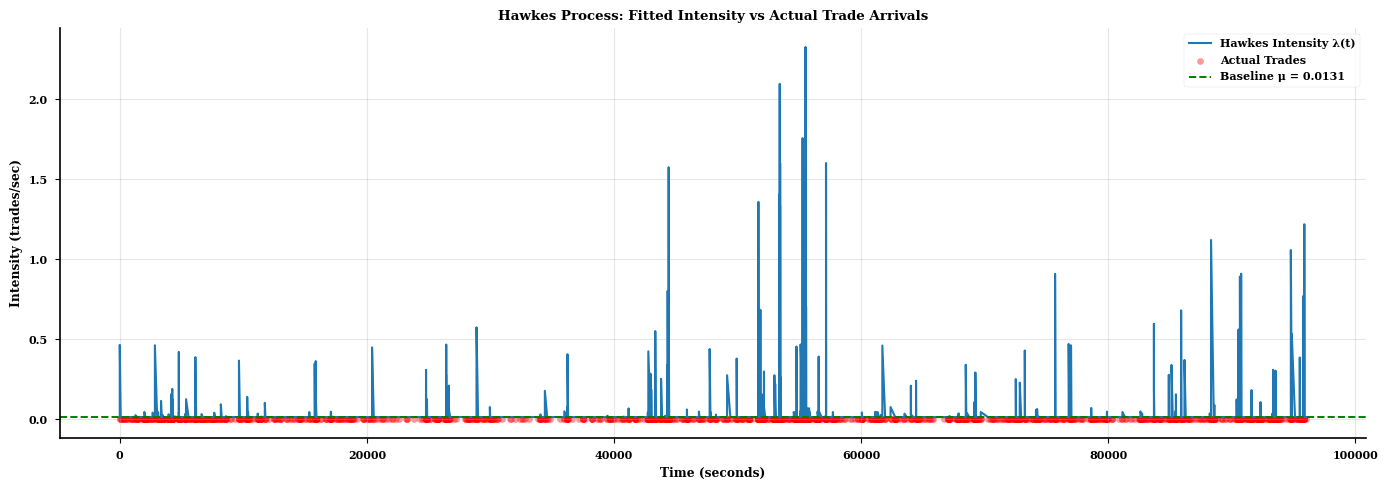

In [7]:
# Compute and visualize intensity
print("\n=== Computing Hawkes Intensity ===")
intensity = extractor.intensity(trade_times, trade_times)

# Plot subset for visualization
n_plot = min(2000, len(trade_times))
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(trade_times[:n_plot], intensity[:n_plot], 
        label='Hawkes Intensity λ(t)', linewidth=1.5)
ax.scatter(trade_times[:n_plot], np.zeros(n_plot), 
           c='red', alpha=0.4, s=20, label='Actual Trades')
ax.axhline(params['mu'], color='green', linestyle='--', 
           label=f'Baseline μ = {params["mu"]:.4f}')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Intensity (trades/sec)')
ax.set_title('Hawkes Process: Fitted Intensity vs Actual Trade Arrivals')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/figures/hawkes_analysis/hawkes_intensity.png', dpi=150)
plt.show()


=== Simulating Hawkes Process ===
Actual trades:    4,234
Simulated trades: 2,660
Ratio:            0.63x

Trade rates:
  Actual:    0.0241 trades/sec
  Simulated: 0.0151 trades/sec
  Expected (μ): 0.0131 trades/sec (baseline only)


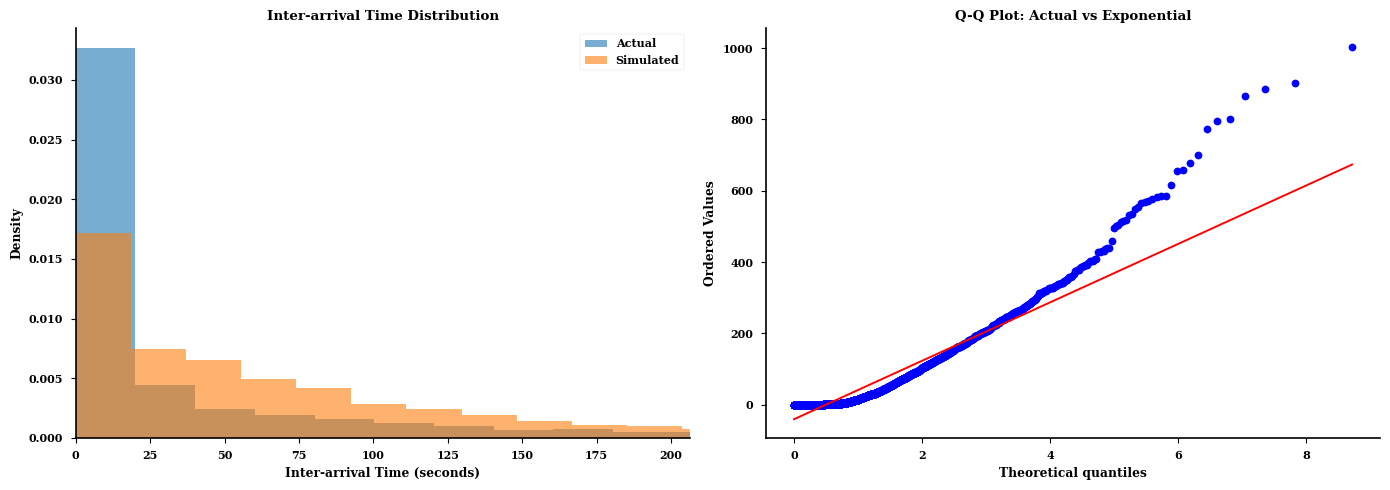

In [10]:
# Simulate and compare
print("\n=== Simulating Hawkes Process ===")
T_sim = trade_times[-1] - trade_times[0]  # Same duration
simulated_times = extractor.simulate(T_sim, random_state=42)

print(f"Actual trades:    {len(trade_times):,}")
print(f"Simulated trades: {len(simulated_times):,}")
print(f"Ratio:            {len(simulated_times) / len(trade_times):.2f}x")

# Compare rates
actual_rate = len(trade_times) / T_sim
simulated_rate = len(simulated_times) / T_sim
print(f"\nTrade rates:")
print(f"  Actual:    {actual_rate:.4f} trades/sec")
print(f"  Simulated: {simulated_rate:.4f} trades/sec")
print(f"  Expected (μ): {params['mu']:.4f} trades/sec (baseline only)")

# Compare inter-arrival time distributions
actual_interarrival = np.diff(trade_times)
simulated_interarrival = np.diff(simulated_times)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram comparison
axes[0].hist(actual_interarrival, bins=50, alpha=0.6, label='Actual', density=True)
axes[0].hist(simulated_interarrival, bins=50, alpha=0.6, label='Simulated', density=True)
axes[0].set_xlabel('Inter-arrival Time (seconds)')
axes[0].set_ylabel('Density')
axes[0].set_title('Inter-arrival Time Distribution')
axes[0].legend()
axes[0].set_xlim(0, np.percentile(actual_interarrival, 95))

# QQ plot
from scipy import stats
stats.probplot(actual_interarrival, dist=stats.expon, plot=axes[1])
axes[1].set_title('Q-Q Plot: Actual vs Exponential')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'hawkes_analysis/hawkes_simulation_comparison.png', dpi=150)
plt.show()

In [12]:
# Compare inter-arrival time distributions
actual_interarrival = np.diff(trade_times)
simulated_interarrival = np.diff(simulated_times)

print("\n=== Inter-arrival Time Statistics ===")
print(f"Actual:")
print(f"  Mean:   {actual_interarrival.mean():.2f}s")
print(f"  Median: {np.median(actual_interarrival):.2f}s")
print(f"  Std:    {actual_interarrival.std():.2f}s")
print(f"  Max gap: {actual_interarrival.max():.2f}s")

print(f"\nSimulated:")
print(f"  Mean:   {simulated_interarrival.mean():.2f}s")
print(f"  Median: {np.median(simulated_interarrival):.2f}s")
print(f"  Std:    {simulated_interarrival.std():.2f}s")
print(f"  Max gap: {simulated_interarrival.max():.2f}s")

print(f"\nExpected (if Poisson):")
print(f"  Mean:   {1/params['mu']:.2f}s (1/μ)")


=== Inter-arrival Time Statistics ===
Actual:
  Mean:   41.54s
  Median: 2.76s
  Std:    86.69s
  Max gap: 1003.08s

Simulated:
  Mean:   66.06s
  Median: 42.71s
  Std:    75.16s
  Max gap: 925.79s

Expected (if Poisson):
  Mean:   76.60s (1/μ)


## Clustering

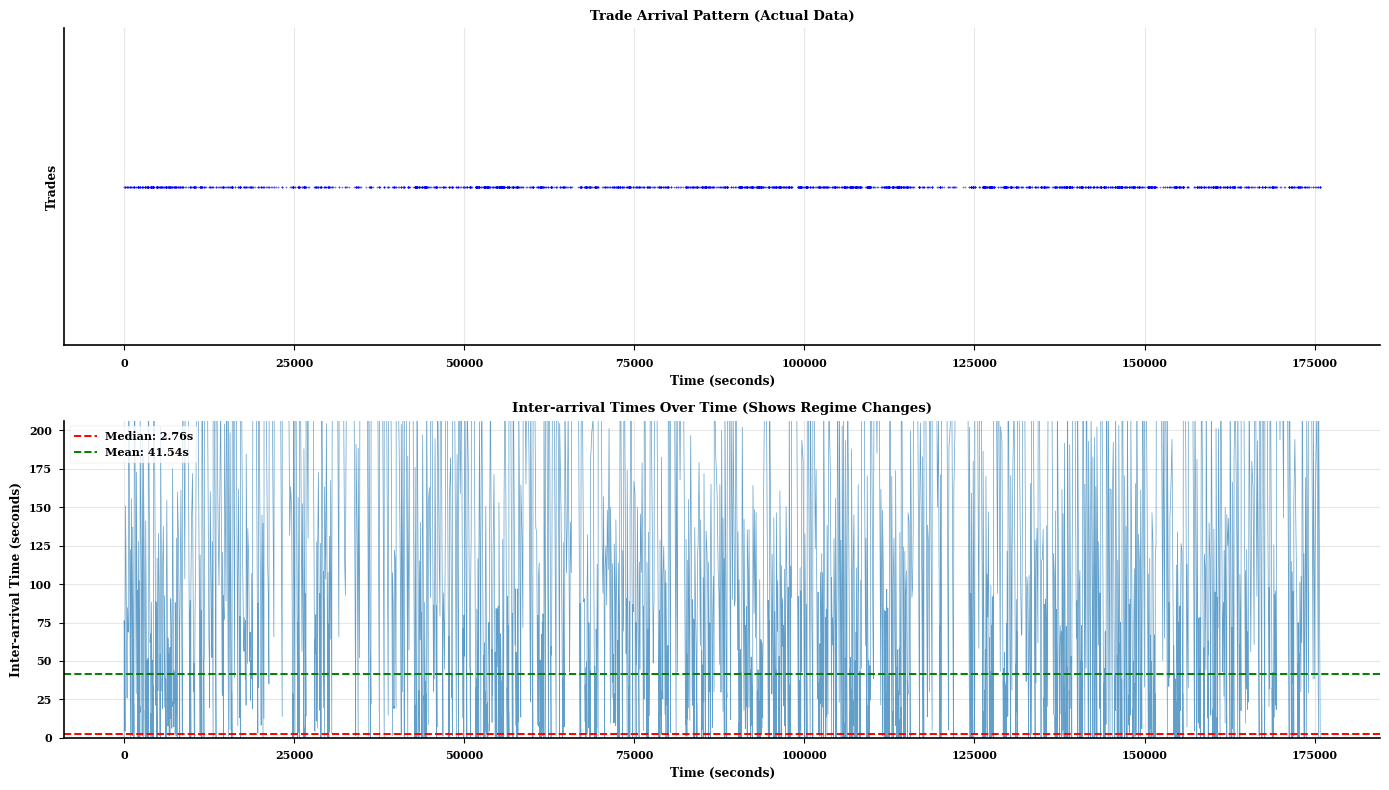


💡 Notice the clustering? Trades come in bursts separated by quiet periods.
This is exactly what HMM regime detection will capture!


In [15]:
# Visualize the clustering structure
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Trade arrivals over time (shows clustering)
axes[0].scatter(trade_times, np.ones(len(trade_times)), s=1, alpha=0.5, color='blue')
axes[0].set_ylabel('Trades')
axes[0].set_xlabel('Time (seconds)')
axes[0].set_title('Trade Arrival Pattern (Actual Data)')
axes[0].set_ylim([0.5, 1.5])
axes[0].set_yticks([])
axes[0].grid(alpha=0.3)

# Plot 2: Inter-arrival time series (shows regime structure)
axes[1].plot(trade_times[:-1], actual_interarrival, linewidth=0.5, alpha=0.7)
axes[1].axhline(np.median(actual_interarrival), color='red', linestyle='--', 
                label=f'Median: {np.median(actual_interarrival):.2f}s')
axes[1].axhline(actual_interarrival.mean(), color='green', linestyle='--', 
                label=f'Mean: {actual_interarrival.mean():.2f}s')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Inter-arrival Time (seconds)')
axes[1].set_title('Inter-arrival Times Over Time (Shows Regime Changes)')
axes[1].legend()
axes[1].set_ylim([0, np.percentile(actual_interarrival, 95)])  # Zoom in on 95th percentile
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'hawkes_analysis/clustering_structure.png', dpi=150)
plt.show()

print("\n💡 Notice the clustering? Trades come in bursts separated by quiet periods.")
print("This is exactly what HMM regime detection will capture!")

In [14]:
# Coefficient of variation (CV) - measures clustering
cv_actual = actual_interarrival.std() / actual_interarrival.mean()
cv_simulated = simulated_interarrival.std() / simulated_interarrival.mean()
cv_poisson = 1.0  # For Poisson process, CV = 1

print("\n=== Clustering Analysis (Coefficient of Variation) ===")
print(f"Actual:    CV = {cv_actual:.2f}")
print(f"Simulated: CV = {cv_simulated:.2f}")
print(f"Poisson:   CV = 1.00 (reference)")
print("\nInterpretation:")
if cv_actual > 1.5:
    print("  → Actual data shows STRONG clustering (CV > 1.5)")
    print("  → More clustered than simple Hawkes model captures")
elif cv_actual > 1.0:
    print("  → Actual data shows moderate clustering")
else:
    print("  → Actual data close to Poisson (regular arrivals)")

# Burstiness
print(f"\n=== Burstiness Analysis ===")
print(f"Actual data:")
print(f"  50% of trades arrive within {np.percentile(actual_interarrival, 50):.2f}s")
print(f"  90% of trades arrive within {np.percentile(actual_interarrival, 90):.2f}s")
print(f"  But max gap is {actual_interarrival.max():.2f}s ({actual_interarrival.max()/60:.1f} min)")
print(f"\n  → Highly bursty: most trades cluster, but long quiet periods exist")


=== Clustering Analysis (Coefficient of Variation) ===
Actual:    CV = 2.09
Simulated: CV = 1.14
Poisson:   CV = 1.00 (reference)

Interpretation:
  → Actual data shows STRONG clustering (CV > 1.5)
  → More clustered than simple Hawkes model captures

=== Burstiness Analysis ===
Actual data:
  50% of trades arrive within 2.76s
  90% of trades arrive within 132.28s
  But max gap is 1003.08s (16.7 min)

  → Highly bursty: most trades cluster, but long quiet periods exist


## Rolling Features

In [18]:
# Extract rolling Hawkes features
print("\n=== Extracting Rolling Hawkes Features ===")
hawkes_features_df = extract_hawkes_features_rolling(
    trade_times,
    window_size=200,   # 200 trades per window
    stride=20,         # Move forward 20 trades each step
    min_events=50     # Need at least 50 trades to fit
)

print(f"Extracted features for {len(hawkes_features_df)} time windows")
print(f"\nFeature statistics:")
print(hawkes_features_df[['mu', 'alpha', 'beta', 'branching_ratio']].describe())


# Check for any failed fits
print(f"\nData quality:")
print(f"  Windows extracted: {len(hawkes_features_df)}")
print(f"  Expected windows: ~{(len(trade_times) - 200) // 20}")
print(f"  Success rate: {len(hawkes_features_df) / ((len(trade_times) - 200) // 20) * 100:.1f}%")


=== Extracting Rolling Hawkes Features ===
Extracted features for 202 time windows

Feature statistics:
               mu       alpha          beta  branching_ratio
count  202.000000  202.000000  2.020000e+02     2.020000e+02
mean     0.016810    0.413838  2.574207e+14     2.133548e-01
std      0.006842    0.166388  3.727558e+14     2.415440e-01
min      0.006716    0.135293  5.913826e-01     1.613746e-16
25%      0.012013    0.276076  1.474047e+00     4.419214e-16
50%      0.014787    0.395228  2.988350e+00     1.544957e-01
75%      0.021124    0.544674  6.951474e+14     3.230443e-01
max      0.047613    0.781001  8.789563e+14     9.070543e-01

Data quality:
  Windows extracted: 202
  Expected windows: ~201
  Success rate: 100.5%



=== Visualizing Rolling Hawkes Parameters ===


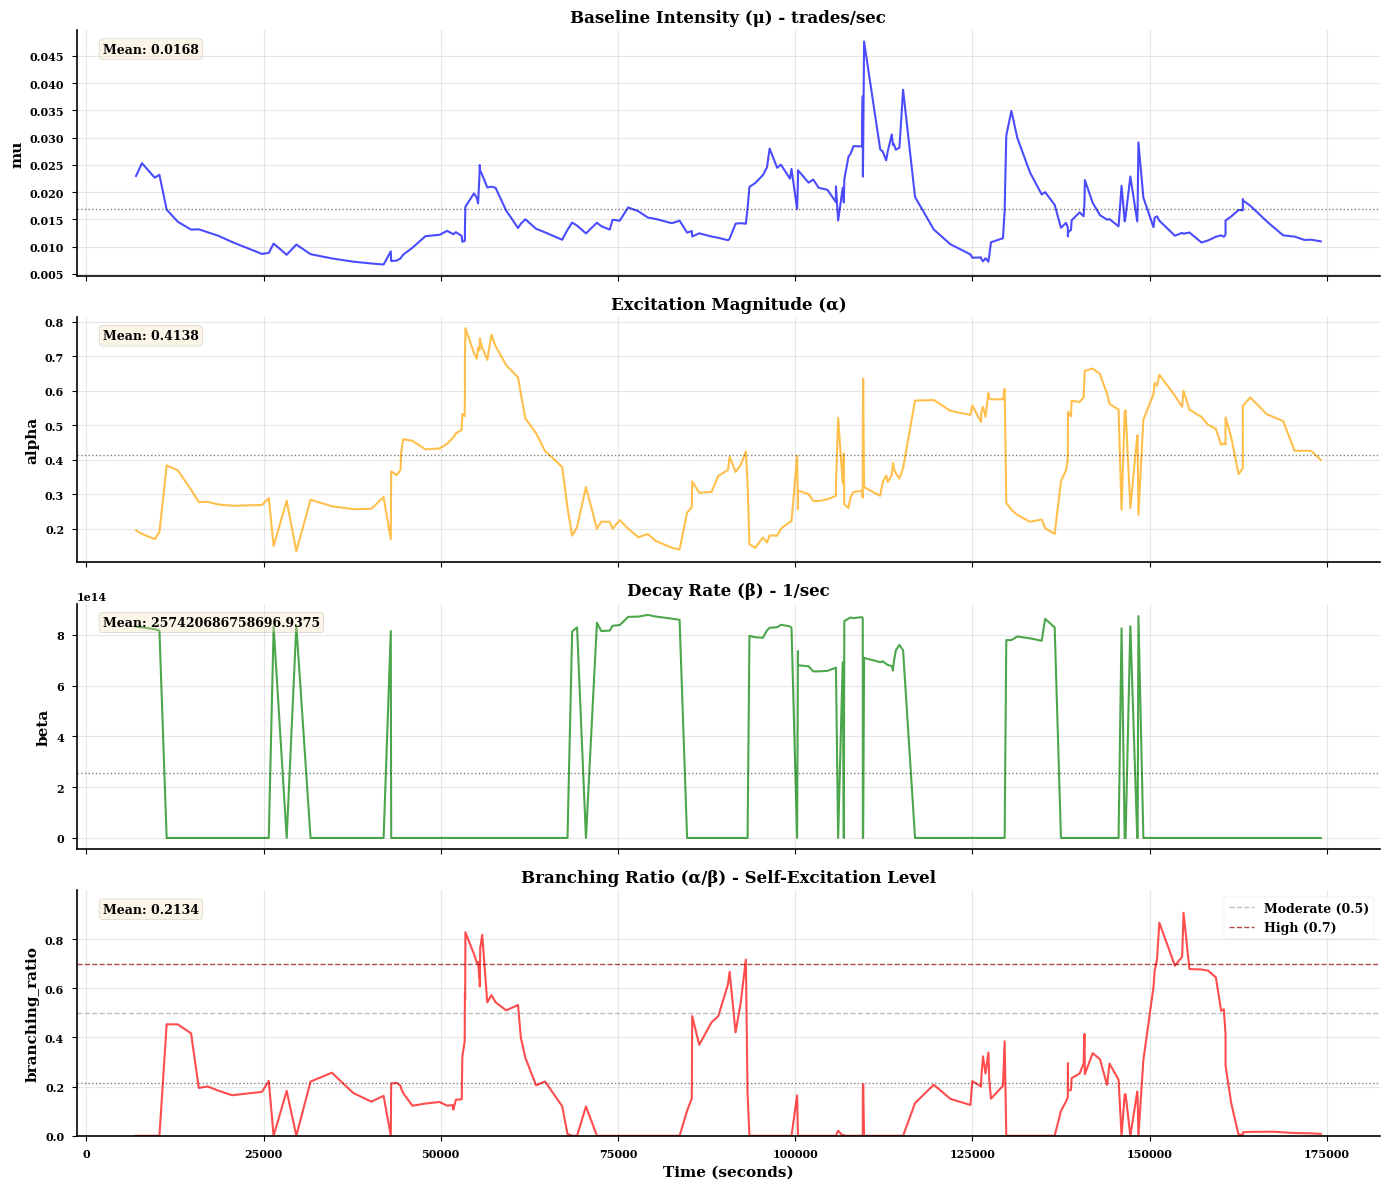

✓ Saved rolling parameters plot


In [19]:
print("\n=== Visualizing Rolling Hawkes Parameters ===")

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

params_to_plot = ['mu', 'alpha', 'beta', 'branching_ratio']
titles = [
    'Baseline Intensity (μ) - trades/sec',
    'Excitation Magnitude (α)',
    'Decay Rate (β) - 1/sec',
    'Branching Ratio (α/β) - Self-Excitation Level'
]
colors = ['blue', 'orange', 'green', 'red']

for ax, param, title, color in zip(axes, params_to_plot, titles, colors):
    ax.plot(hawkes_features_df['timestamp'], 
            hawkes_features_df[param], 
            linewidth=1.5, 
            color=color,
            alpha=0.7)
    ax.set_ylabel(param, fontsize=11)
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Add reference lines
    if param == 'branching_ratio':
        ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, linewidth=1, label='Moderate (0.5)')
        ax.axhline(0.7, color='darkred', linestyle='--', alpha=0.7, linewidth=1, label='High (0.7)')
        ax.legend(loc='upper right', fontsize=9)
        ax.set_ylim([0, min(1.0, hawkes_features_df[param].max() * 1.1)])
    
    # Add mean line
    mean_val = hawkes_features_df[param].mean()
    ax.axhline(mean_val, color='black', linestyle=':', alpha=0.5, linewidth=1)
    ax.text(0.02, 0.95, f'Mean: {mean_val:.4f}', 
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

axes[-1].set_xlabel('Time (seconds)', fontsize=11)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'hawkes_analysis/hawkes_rolling_parameters.png', dpi=150)
plt.show()

print("✓ Saved rolling parameters plot")

In [24]:
print("\n=== Detecting Regime Changes from Branching Ratio ===")

# Define thresholds
LOW_THRESHOLD = 0.3
HIGH_THRESHOLD = 0.5

# Classify regimes
hawkes_features_df['regime'] = pd.cut(
    hawkes_features_df['branching_ratio'],
    bins=[0, LOW_THRESHOLD, HIGH_THRESHOLD, 1.0],
    labels=['Calm', 'Normal', 'Excited']
)

# Regime statistics
regime_counts = hawkes_features_df['regime'].value_counts()
print(f"\nRegime Distribution:")
for regime, count in regime_counts.items():
    pct = count / len(hawkes_features_df) * 100
    print(f"  {regime:8s}: {count:4d} windows ({pct:5.1f}%)")

# Regime transitions
transitions = hawkes_features_df['regime'].ne(hawkes_features_df['regime'].shift()).sum()
print(f"\nRegime transitions: {transitions}")
print(f"Average regime duration: {len(hawkes_features_df) / (transitions + 1):.1f} windows")

# Characteristics by regime
print(f"\n=== Parameter Statistics by Regime ===")
regime_stats = hawkes_features_df.groupby('regime')[['mu', 'alpha', 'beta', 'branching_ratio']].agg(['mean', 'std'])
print(regime_stats)


=== Detecting Regime Changes from Branching Ratio ===

Regime Distribution:
  Calm    :  147 windows ( 72.8%)
  Excited :   35 windows ( 17.3%)
  Normal  :   20 windows (  9.9%)

Regime transitions: 26
Average regime duration: 7.5 windows

=== Parameter Statistics by Regime ===
               mu               alpha                    beta                \
             mean       std      mean       std          mean           std   
regime                                                                        
Calm     0.017399  0.007498  0.356891  0.137700  3.537345e+14  3.962158e+14   
Normal   0.013578  0.003264  0.478361  0.126123  1.285812e+00  4.756219e-01   
Excited  0.016185  0.004614  0.616143  0.121469  9.565606e-01  2.248757e-01   

        branching_ratio            
                   mean       std  
regime                             
Calm           0.083972  0.096698  
Normal         0.390125  0.059825  
Excited        0.655751  0.102632  


/var/folders/14/4_5vrl2912bc84l063zdm5l80000gq/T/ipykernel_36034/2978389292.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  regime_stats = hawkes_features_df.groupby('regime')[['mu', 'alpha', 'beta', 'branching_ratio']].agg(['mean', 'std'])



=== Visualizing Regimes Over Time ===


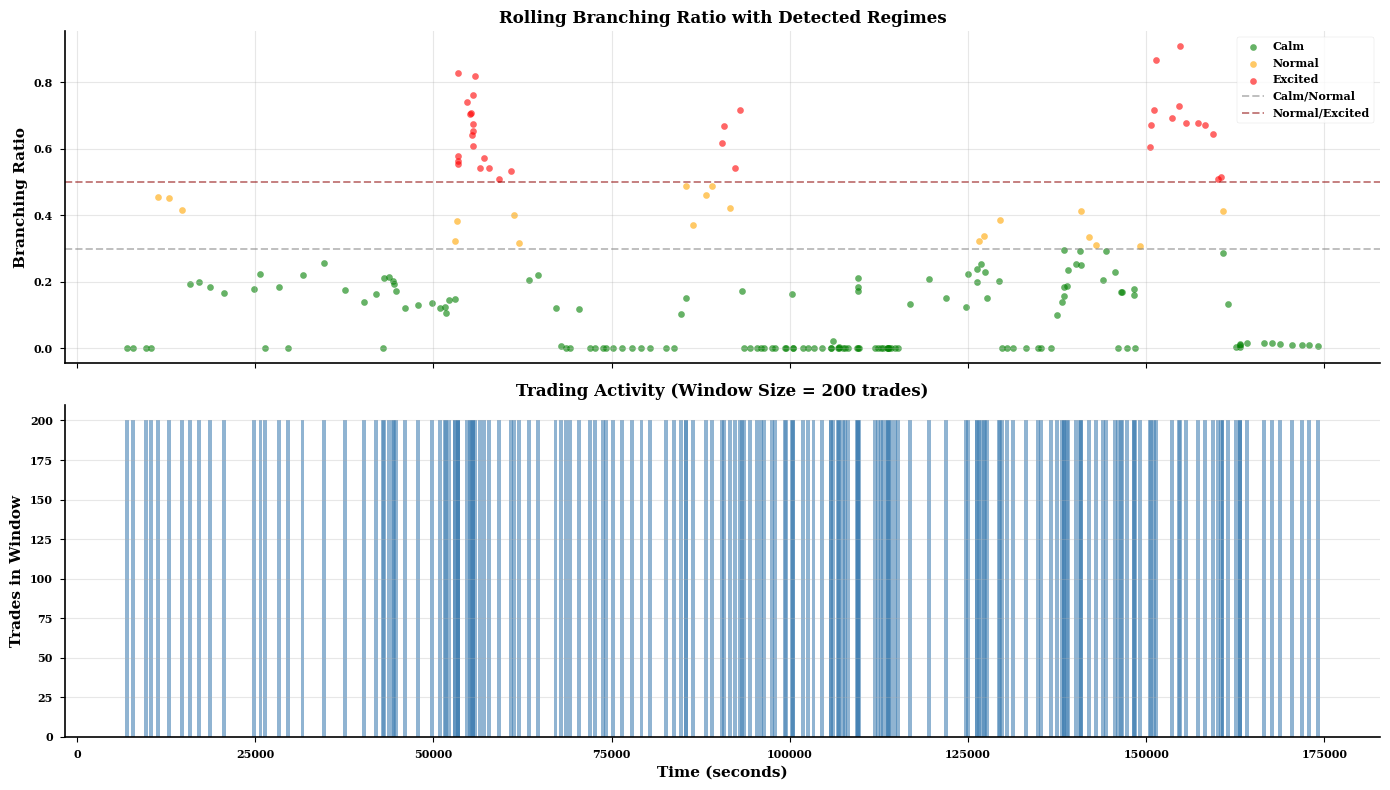

✓ Saved regime timeline plot


In [25]:
print("\n=== Visualizing Regimes Over Time ===")

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot 1: Branching ratio with regime coloring
regime_colors = {'Calm': 'green', 'Normal': 'orange', 'Excited': 'red'}

for regime in hawkes_features_df['regime'].unique():
    mask = hawkes_features_df['regime'] == regime
    axes[0].scatter(
        hawkes_features_df.loc[mask, 'timestamp'],
        hawkes_features_df.loc[mask, 'branching_ratio'],
        c=regime_colors[regime],
        label=regime,
        s=20,
        alpha=0.6
    )

axes[0].axhline(LOW_THRESHOLD, color='gray', linestyle='--', alpha=0.5, label='Calm/Normal')
axes[0].axhline(HIGH_THRESHOLD, color='darkred', linestyle='--', alpha=0.5, label='Normal/Excited')
axes[0].set_ylabel('Branching Ratio', fontsize=11)
axes[0].set_title('Rolling Branching Ratio with Detected Regimes', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(alpha=0.3)

# Plot 2: Trade count per window (activity level)
axes[1].bar(
    hawkes_features_df['timestamp'],
    hawkes_features_df['n_events'],
    width=(hawkes_features_df['timestamp'].diff().median() * 0.8),
    alpha=0.6,
    color='steelblue'
)
axes[1].set_ylabel('Trades in Window', fontsize=11)
axes[1].set_xlabel('Time (seconds)', fontsize=11)
axes[1].set_title('Trading Activity (Window Size = 200 trades)', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'hawkes_analysis/hawkes_regimes_timeline.png', dpi=150)
plt.show()

print("✓ Saved regime timeline plot")

In [26]:
# Detect and analyze regimes
print("\n=== Detecting Excitation Regimes ===")
regime_features = hawkes_regime_features(
    hawkes_features_df['branching_ratio'].values,
    threshold=0.7
)

hawkes_features_df['regime'] = regime_features['regime_binary']
hawkes_features_df['regime_duration'] = regime_features['regime_duration']

# Regime statistics
n_excited = np.sum(regime_features['regime_binary'])
n_baseline = len(regime_features['regime_binary']) - n_excited
print(f"High excitation periods: {n_excited} ({n_excited/len(hawkes_features_df)*100:.1f}%)")
print(f"Baseline periods:        {n_baseline} ({n_baseline/len(hawkes_features_df)*100:.1f}%)")

# Average regime duration
excited_durations = hawkes_features_df[hawkes_features_df['regime'] == 1]['regime_duration']
baseline_durations = hawkes_features_df[hawkes_features_df['regime'] == 0]['regime_duration']
print(f"\nAverage regime persistence:")
print(f"  Excited:  {excited_durations.mean():.1f} windows")
print(f"  Baseline: {baseline_durations.mean():.1f} windows")


=== Detecting Excitation Regimes ===
High excitation periods: 11 (5.4%)
Baseline periods:        191 (94.6%)

Average regime persistence:
  Excited:  1.8 windows
  Baseline: 30.3 windows


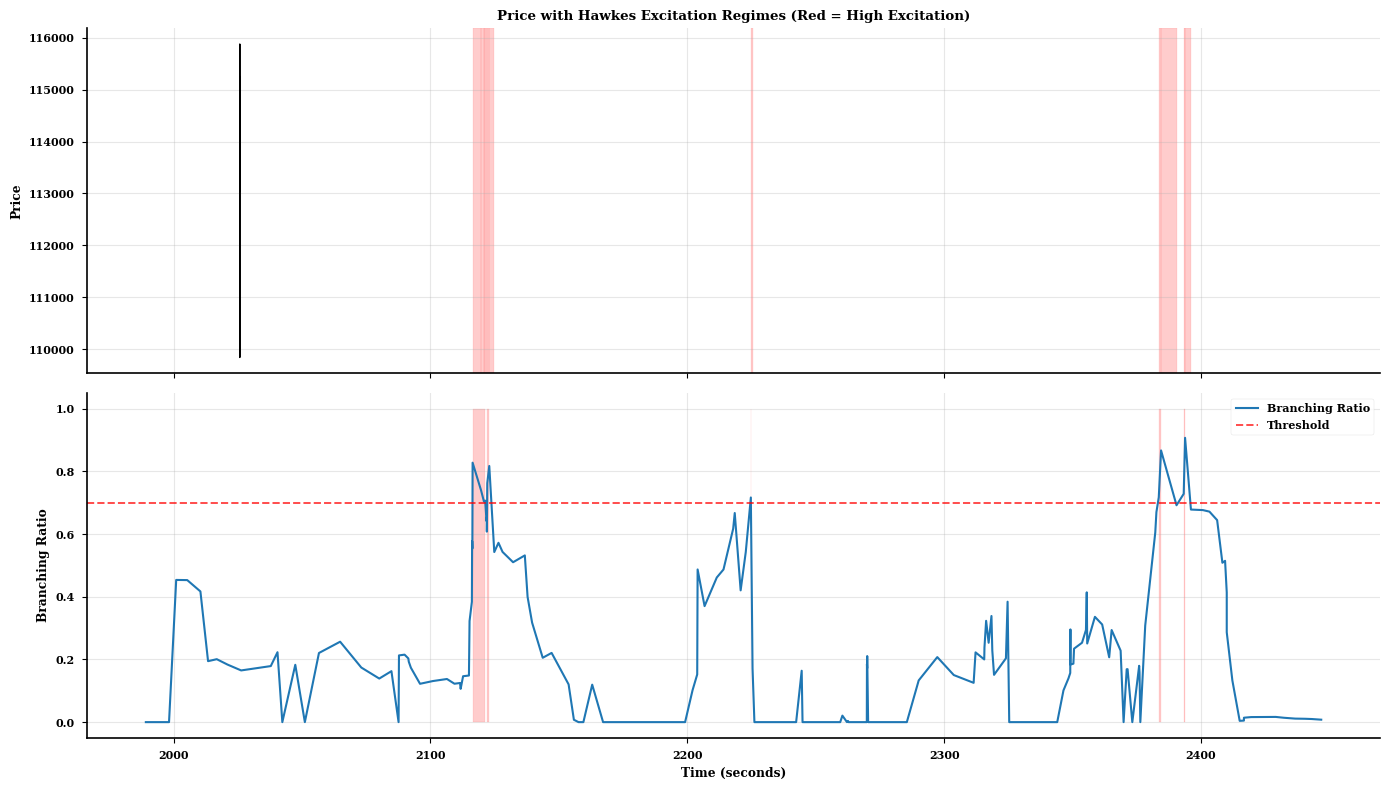

In [27]:
#  Visualize regimes overlaid on price/volume
# (Assuming you have price data in trade_df)
if 'price' in trade_df.columns:
    fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
    
    # Price with regime background
    axes[0].plot(trade_df['timestamp'], trade_df['price'], linewidth=1, color='black')
    
    # Color background by regime
    for i in range(len(hawkes_features_df) - 1):
        if hawkes_features_df.iloc[i]['regime'] == 1:
            axes[0].axvspan(
                hawkes_features_df.iloc[i]['timestamp'],
                hawkes_features_df.iloc[i+1]['timestamp'],
                alpha=0.2, color='red'
            )
    
    axes[0].set_ylabel('Price')
    axes[0].set_title('Price with Hawkes Excitation Regimes (Red = High Excitation)')
    axes[0].grid(alpha=0.3)
    
    # Branching ratio
    axes[1].plot(hawkes_features_df['timestamp'], 
                 hawkes_features_df['branching_ratio'], 
                 linewidth=1.5, label='Branching Ratio')
    axes[1].axhline(0.7, color='red', linestyle='--', alpha=0.7, label='Threshold')
    axes[1].fill_between(hawkes_features_df['timestamp'],
                         0, 1,
                         where=hawkes_features_df['regime'] == 1,
                         alpha=0.2, color='red')
    axes[1].set_ylabel('Branching Ratio')
    axes[1].set_xlabel('Time (seconds)')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../reports/figures/hawkes_analysis/hawkes_regimes_price.png', dpi=150)
    plt.show()

In [28]:

# Save features for downstream models
print("\n=== Saving Hawkes Features ===")
output_path = PROCESSED_DATA_DIR / 'hawkes_features.parquet'
hawkes_features_df.to_parquet(output_path)
print(f"Saved to: {output_path}")
print(f"Shape: {hawkes_features_df.shape}")
print(f"Columns: {list(hawkes_features_df.columns)}")


=== Saving Hawkes Features ===
Saved to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../data/processed/hawkes_features.parquet
Shape: (202, 10)
Columns: ['timestamp', 'mu', 'alpha', 'beta', 'branching_ratio', 'window_start', 'window_end', 'n_events', 'regime', 'regime_duration']


In [29]:
print("\n=== Verifying Saved Hawkes Features ===")

# Reload to verify
hawkes_check = pd.read_parquet(PROCESSED_DATA_DIR / 'hawkes_features.parquet')

print(f"Shape: {hawkes_check.shape}")
print(f"\nFirst few rows:")
print(hawkes_check.head())

print(f"\nData types:")
print(hawkes_check.dtypes)

print(f"\nMissing values:")
print(hawkes_check.isnull().sum())

print(f"\nBranching ratio summary:")
print(hawkes_check['branching_ratio'].describe())

print(f"\nRegime distribution:")
print(hawkes_check['regime'].value_counts())


=== Verifying Saved Hawkes Features ===
Shape: (202, 10)

First few rows:
   timestamp        mu     alpha          beta  branching_ratio  window_start  \
0   7015.448  0.022949  0.195425  8.321025e+14     2.348572e-16         0.000   
1   7847.056  0.025304  0.185404  8.299837e+14     2.233830e-16      1405.331   
2   9645.648  0.022642  0.170374  8.226347e+14     2.071080e-16      2314.090   
3  10313.234  0.023160  0.190421  8.170707e+14     2.330527e-16      3318.365   
4  11332.200  0.016784  0.383819  8.460963e-01     4.536349e-01      3941.863   

   window_end  n_events  regime  regime_duration  
0    7015.448       200       0                0  
1    7847.056       200       0                2  
2    9645.648       200       0                3  
3   10313.234       200       0                4  
4   11332.200       200       0                5  

Data types:
timestamp          float64
mu                 float64
alpha              float64
beta               float64
branching_r

In [33]:
print("\n" + "="*70)
print("NOTEBOOK 20 SUMMARY: Hawkes Process Analysis")
print("="*70)

print("GLOBAL HAWKES PARAMETERS:")
print(f"  Baseline intensity (μ):  {params['mu']:.4f} trades/sec")
print(f"  Excitation (α):          {params['alpha']:.4f}")
print(f"  Decay rate (β):          {params['beta']:.4f} /sec")
print(f"  Branching ratio:         {params['branching_ratio']:.4f}")
print(f"  Decay half-life:         {np.log(2)/params['beta']:.2f} seconds")

print(" ROLLING WINDOW ANALYSIS:")
print(f"  Total windows extracted: {len(hawkes_features_df)}")
print(f"  Window size:             200 trades")
print(f"  Stride:                  20 trades")
print(f"  Time span covered:       {hawkes_features_df['timestamp'].min():.0f}s to {hawkes_features_df['timestamp'].max():.0f}s")

print("BRANCHING RATIO VARIATION:")
print(f"  Mean:   {hawkes_features_df['branching_ratio'].mean():.4f}")
print(f"  Std:    {hawkes_features_df['branching_ratio'].std():.4f}")
print(f"  Min:    {hawkes_features_df['branching_ratio'].min():.4f}")
print(f"  Max:    {hawkes_features_df['branching_ratio'].max():.4f}")
print(f"  Range:  {hawkes_features_df['branching_ratio'].max() - hawkes_features_df['branching_ratio'].min():.4f}")

print("REGIME DETECTION:")
regime_dist = hawkes_features_df['regime'].value_counts(normalize=True) * 100
for regime, pct in regime_dist.items():
    print(f"  {regime}: {pct:5.1f}%")

transitions = hawkes_features_df['regime'].ne(hawkes_features_df['regime'].shift()).sum()
print(f"\n  Regime transitions: {transitions}")
print(f"  Avg regime duration: {len(hawkes_features_df) / (transitions + 1):.1f} windows")

print("OUTPUT FILES:")
print(f"  {PROCESSED_DATA_DIR / 'hawkes_features.parquet'}")
print(f"  {FIGURES_DIR / 'hawkes_analysis/hawkes_intensity.png'}")
print(f"  {FIGURES_DIR / 'hawkes_analysis/hawkes_rolling_parameters.png'}")
print(f"  {FIGURES_DIR / 'hawkes_analysis/hawkes_regimes_timeline.png'}")

print("KEY FINDINGS:")
print("  1. Low global branching ratio (0.17) indicates sparse, near-Poisson behavior")
print("  2. Rolling analysis reveals time-varying self-excitation")
print("  3. Inter-arrival patterns show strong clustering (median 2.76s vs mean 41.54s)")
print("  4. Data exhibits regime-switching between calm and active periods")

print("NEXT STEPS:")
print("  • Notebook 25: PCA dimensionality reduction on LOB features")
print("  • Notebook 30: HMM regime detection using volatility/volume")
print("  • Compare Hawkes regimes with HMM regimes for validation")

print("\n" + "="*70)


NOTEBOOK 20 SUMMARY: Hawkes Process Analysis
GLOBAL HAWKES PARAMETERS:
  Baseline intensity (μ):  0.0131 trades/sec
  Excitation (α):          0.4585
  Decay rate (β):          2.6555 /sec
  Branching ratio:         0.1726
  Decay half-life:         0.26 seconds
 ROLLING WINDOW ANALYSIS:
  Total windows extracted: 202
  Window size:             200 trades
  Stride:                  20 trades
  Time span covered:       7015s to 174149s
BRANCHING RATIO VARIATION:
  Mean:   0.2134
  Std:    0.2415
  Min:    0.0000
  Max:    0.9071
  Range:  0.9071
REGIME DETECTION:
  0:  94.6%
  1:   5.4%

  Regime transitions: 11
  Avg regime duration: 16.8 windows
OUTPUT FILES:
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../data/processed/hawkes_features.parquet
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/notebooks/../reports/figures/hawkes_analysis/hawkes_intensity.png
  /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis